# Tutorial 11: DeepWalk and node2vec - Implementation details
  
Notebooks based on PyTorch Geometric tutorial on node embeddings, see [here](https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post11.html)

# Setup

In [35]:
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


In [51]:
!pip install annoy

     |████████████████████████████████| 646 kB 5.0 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391671 sha256=55bbdab31d3222248b6f3de85457ebe14608594e3a61cfa282510b43990fd1e6
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [63]:
from torch_geometric.nn import Node2Vec
import torch_cluster
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from ast import literal_eval
from scipy.spatial.distance import cosine
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import numpy as np
from annoy import AnnoyIndex
import seaborn as sns
sns.set()

In [37]:
!unzip wikidata_gazetteer.csv.zip

Archive:  wikidata_gazetteer.csv.zip
replace wikidata_gazetteer.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [38]:
gaz = pd.read_csv('wikidata_gazetteer.csv')
print(gaz.shape)
def eval_with_exception(string):
    try:
        return literal_eval(string)
    except ValueError:
        return None
gaz['instance_of'] = gaz['instance_of'].apply(eval_with_exception)
instances_all = [i for l in gaz[~gaz.instance_of.isnull()].instance_of for i in l if l]
instances = set(instances_all)

id2lab = dict(zip(range(len(instances)),instances))
lab2id = {j:i for i,j in id2lab.items()}


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(929854, 29)


In [39]:
nodes = []
from collections import Counter
node_weights = Counter(instances_all)

for n_id,lab in id2lab.items():
    vector = np.zeros(len(instances),dtype=np.int8)
    vector[n_id] = 1
    nodes.append((n_id,{"y": n_id,
                        #'x': vector,
                        'x': n_id,
                        #'name':lab,
                        'weight' : node_weights[lab]})) 
print(nodes[:4])

[(0, {'y': 0, 'x': 0, 'weight': 2}), (1, {'y': 1, 'x': 1, 'weight': 1}), (2, {'y': 2, 'x': 2, 'weight': 22}), (3, {'y': 3, 'x': 3, 'weight': 3})]


In [40]:
edges_all = []
for el in gaz[~gaz.instance_of.isnull()].instance_of:
    if len(el) > 1:
        el = sorted(el)
        bigrams = list(zip(el[:-1],el[1:]))
        for b in bigrams:
            edges_all.append((lab2id[b[0]],lab2id[b[1]]))
edges_weights = Counter(edges_all)
edges = []
for (l,g),v in edges_weights.items():
  edges.append((l,g,v))
print(edges[:3])


[(6832, 1194, 2290), (13147, 12408, 15), (5664, 1286, 375)]


In [41]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)
data_all = from_networkx(G)

In [42]:
from torch_geometric.transforms.remove_isolated_nodes import RemoveIsolatedNodes
remove_isolated_nodes = RemoveIsolatedNodes()
data = remove_isolated_nodes(data_all)

In [43]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 9915
Number of edges: 63567
Average node degree: 6.41
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [45]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [46]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Training

In [47]:
for epoch in range(1, 20):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 01, Loss: 7.2180


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 02, Loss: 4.0892


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 03, Loss: 2.7021


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 04, Loss: 1.9347


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 05, Loss: 1.4917


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 06, Loss: 1.2430


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 07, Loss: 1.1072


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 08, Loss: 1.0319


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.9892


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.9619


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.9451


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.9336


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.9256


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.9187


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.9145


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.9099


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.9072


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.9044


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.9030


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


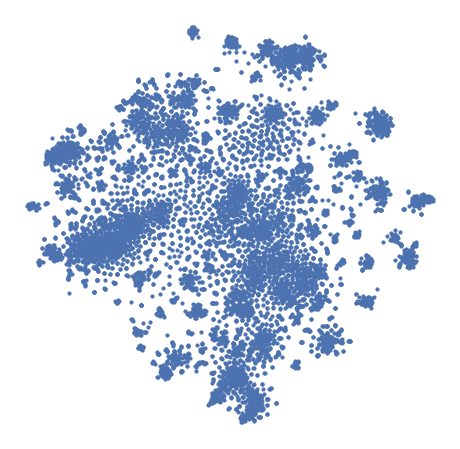

In [48]:
model.eval()

emb = model(torch.arange(data.num_nodes, device=device))
z = TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy())

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], s=10)
plt.axis('off')
plt.show()

In [49]:
node_names = np.array([id2lab[i] for i in data.x.numpy()])

In [50]:
print(node_names)
print(len(node_names))
node_names[0]

['Q1527105' 'Q135010' 'Q20616831' ... 'Q2153495' 'Q216778' 'Q1770467']
9915


'Q1527105'

In [53]:


f = 128  

t = AnnoyIndex(f, 'angular')
for i,v in enumerate(emb):
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('embeddings.index')

True

In [54]:
idx = 50
print(node_names[idx])

Q15343039


In [55]:
nn = t.get_nns_by_item(idx, 10)
node_names[nn]

array(['Q15343039', 'Q107095432', 'Q10558666', 'Q2983548', 'Q54111',
       'Q79119969', 'Q12289746', 'Q1191610', 'Q108860593', 'Q47775614'],
      dtype='<U10')

In [56]:
np.save(open('embeddings.npy','wb'), emb.detach().numpy())

In [57]:
open('wikidata_ids.txt','w').write('\n'.join(node_names))

89170

In [59]:
relevant_classes_ = {"Q6256": "country",
                         "Q5107": "continent",
                         "Q56061": "administrative territorial entity", 
                         "Q15284": "municipality",
                         "Q34442": "road",
                         "Q41176": "building",
                         "Q123705": "neighborhood",
                         "Q4022": "river",
                         "Q23442": "island",
                         "Q1138494": "historic county"}


dict_values(['country', 'continent', 'administrative territorial entity', 'municipality', 'road', 'building', 'neighborhood', 'river', 'island', 'historic county'])

In [60]:
relevant_classes = ["Q6256","Q5107","Q56061","Q15284","Q34442",
                         "Q41176","Q123705","Q4022","Q23442"]
relevant_labels = ["country","continent","administrative territorial entity",
                  "municipality","road", "building","neighborhood","river",
                  "island"]

In [61]:
relevant_ids = [list(node_names).index(i) for i in relevant_classes]
target = [emb[i].detach().numpy() for i in relevant_ids]


In [64]:

def get_class(embedding,target):
  embedding = embedding.detach().numpy()
  return np.argmin([cosine(embedding,target[i]) for i in  range(len(target ))])
  

In [65]:
classes = np.array([get_class(emb[i],target) for i in range(len(emb))])

In [ ]:
model.eval()
emb = model(torch.arange(data.num_nodes, device=device))
z = TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


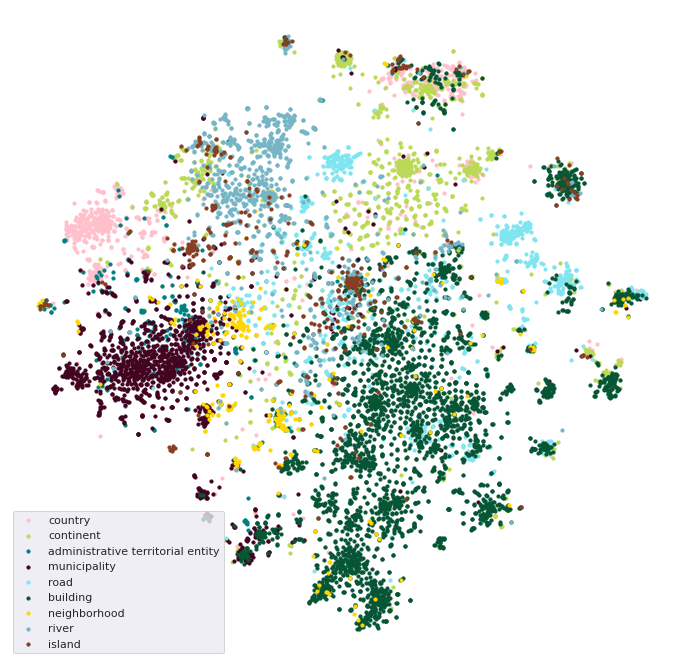

In [66]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700','#76b5c5','#873e23',
]



y = classes#data.y.cpu().numpy()

plt.figure(figsize=(12, 12))
for i in range(len(set(classes))):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=10, label=relevant_labels[i], color=colors[i])
plt.legend()
plt.axis('off')
plt.show()


